<h1 style="font-size:30px;">Application: Creating Panoramas</h1> 

Have you ever wondered what goes on under the hood when you take a picture in panorama mode? Multiple computer vision techniques are involved in creating a simple panorama. While a lot more goes into creating a good panorama, the basic principle is to align the concerned images using a homography and stitching them intelligently so that you do not see the seams. 

<br>
<center>
<img src="https://opencv.org/wp-content/uploads/2021/09/c0-m11-panaroma-feature-image.png" alt="c0-m11-panaroma-feature-image.png">
</center>
<br>

## <font style="color:rgb(50,120,229)">Overview</font>

The technique we will use is often called “feature-based” image alignment because in this technique a sparse set of features are detected in one image and matched with the features in the other image. A transformation (Homography) is then calculated based on these matched features and is ten used to warp one image onto the other. We have already seen how we can use Homography between two images to align one image with respect to another. Once the second image is aligned with respect to the first image, we can simply stitch the first image with the aligned second image to obtain a Panorama. The two images below were taken by rotating the camera about the axis perpendicular to the optical axis of the camera. 

<br>
<center>
<img src="https://opencv.org/wp-content/uploads/2021/09/c0-m11-panaroma-image1-image2.png" alt="c0-m11-panaroma-image1-image2.png">
</center>
<br>

# 1. Work Flow

Creating a panorama for 2 images consists of the following steps: 
* Find keypoints and descriptors for both images
* Find the corresponding points by matching their descriptors
* Computing the homography that relates the two images
* Use the homography to warp the perspective of the 2nd image
* Combine ("stitch") the first image with the warped image to create the Panorama

<hr style="border:none; height: 4px; background-color:#D3D3D3" />

### <font color="green">OpenCV Documentation</font>


[**`detectAndCompute()`**](https://docs.opencv.org/4.5.2/d0/d13/classcv_1_1Feature2D.html#a8be0d1c20b08eb867184b8d74c15a677)
[**`drawKeypoints()`**](https://docs.opencv.org/4.5.2/d4/d5d/group__features2d__draw.html#ga5d2bafe8c1c45289bc3403a40fb88920)
[**`match()`**](https://docs.opencv.org/4.5.2/db/d39/classcv_1_1DescriptorMatcher.html#a0f046f47b68ec7074391e1e85c750cba)
[**`drawMatches()`**](https://docs.opencv.org/4.5.2/d4/d5d/group__features2d__draw.html#gad8f463ccaf0dc6f61083abd8717c261a)
[**`findHomography()`**](https://docs.opencv.org/4.5.2/d9/d0c/group__calib3d.html#ga4abc2ece9fab9398f2e560d53c8c9780)
[**`warpPerspective()`**](https://docs.opencv.org/4.5.2/da/d54/group__imgproc__transform.html#gaf73673a7e8e18ec6963e3774e6a94b87)


<hr style="border:none; height: 4px; background-color:#D3D3D3" />

# 2. Find Keypoints and Descriptors

In many Computer Vision applications, we often need to identify interesting stable points in an image. These points are called keypoints or feature points. The ORB class in OpenCV implements the ORB (Oriented FAST and Rotated BRIEF) keypoint detector and descriptor extractor. <a href="https://docs.opencv.org/4.5.2/d1/d89/tutorial_py_orb.html" alt="ORB" target="">ORB (Oriented FAST and Rotated BRIEF) Tutorial</a>

1. **Locator**: This identifies points on the image that are stable under image transformations like translation (shift), scale (increase / decrease in size), and rotation. The locator finds the `(x,y)` coordinates of such points. The locator used by the ORB detector is called <a href="https://docs.opencv.org/3.4/df/d0c/tutorial_py_fast.html" alt="FAST" target="_blank">FAST</a>.
2. **Descriptor**: The locator in the above step only tells us the location of interesting points. The second part of the feature detector is the descriptor which encodes the appearance of the point so that we can distinguish one feature point from the other. The descriptor evaluated at a feature point is simply an array of numbers. Ideally, the same physical point in two images should have the same descriptor. The algorithm used in OpenCV to compute the descriptor is called <a href="https://docs.opencv.org/3.4/dc/d7d/tutorial_py_brief.html" alt="BRIEF" target="_blank">BRIEF</a>.

In [ ]:
if 'google.colab' in str(get_ipython()):
    print("Downloading Code to Colab Environment")
    !wget https://www.dropbox.com/sh/vuiu1n95x2q6q7q/AAANt6Y9G_e5WwsqbXTaqtqza?dl=1 -O module-code.zip -q --show-progress
    !unzip -qq module-code.zip
    %cd Applications/
else:
    pass

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import glob
%matplotlib inline
import matplotlib
plt.rcParams['image.cmap'] = 'gray'

### <font style="color:rgb(50,120,230)">Read the images and convert to grayscale</font>

In [2]:
image_file1 = "./scene/scene1.jpg"  # Reference image.
image_file2 = "./scene/scene3.jpg"  # Image to be aligned.

# Read the images.
img1 = cv2.imread(image_file1, cv2.IMREAD_COLOR)
img2 = cv2.imread(image_file2, cv2.IMREAD_COLOR)

# Convert images to grayscale.
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

### <font style="color:rgb(50,120,230)">Compute the Keypoints and Descriptors</font>

In [3]:
# Detect ORB features and compute descriptors.
MAX_FEATURES = 500 
orb = cv2.ORB_create(MAX_FEATURES)
keypoints1, descriptors1 = orb.detectAndCompute(img1_gray, None)
keypoints2, descriptors2 = orb.detectAndCompute(img2_gray, None)

## 2.1 Draw the Keypoints

In [4]:
img1_keypoints = cv2.drawKeypoints(img1, keypoints1, None, color = (0,0,255),flags = cv2.DRAW_MATCHES_FLAGS_DEFAULT)
img2_keypoints = cv2.drawKeypoints(img2, keypoints2, None, color = (0,0,255),flags = cv2.DRAW_MATCHES_FLAGS_DEFAULT)

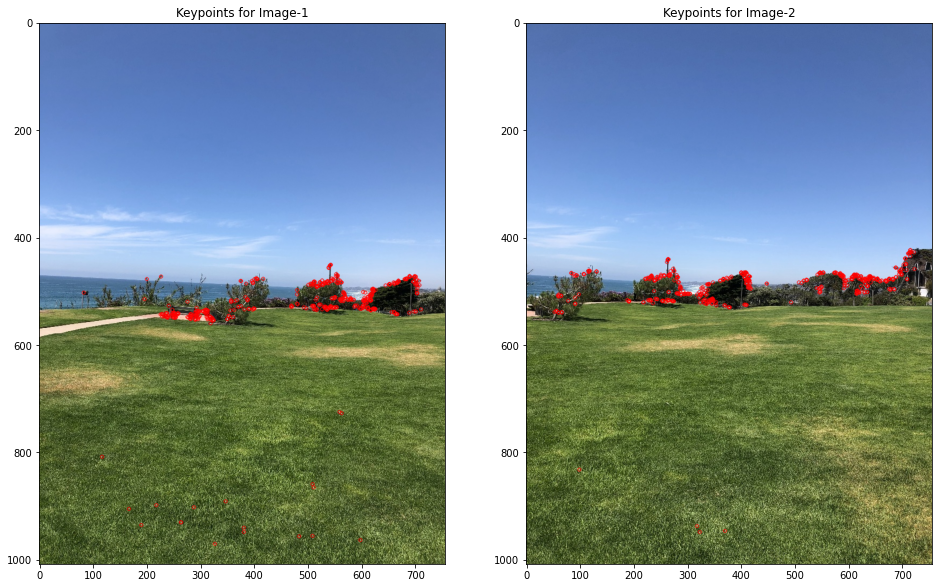

In [5]:
plt.figure(figsize = [16, 10])
plt.subplot(121); plt.imshow(img1_keypoints[:,:,::-1]); plt.title("Keypoints for Image-1")
plt.subplot(122); plt.imshow(img2_keypoints[:,:,::-1]); plt.title("Keypoints for Image-2");

# 3. Find Matching Corresponding Points
The homography that relates the two images can be calculated only if we know the corresponding features in the two images. So a matching algorithm is used to find which features in one image match features in the other image. For this purpose, the descriptor of every feature in one image is compared to the descriptor of every feature in the second image to find good matches. We use hamming distance as a measure of similarity.
It should be noted that we have many incorrect matches and therefore we will need to use a robust method to calculate homography.


For matching the descriptors we will use the `DescriptorMatcher` present in OpenCV to find the matching scores between descriptors in image1 and image2.
The naming used in OpenCV for Descriptor Matcher is a bit unconventional. The Descriptor Matcher object ( matcher in our case ) takes in two arrays of descriptors. The first argument is named `queryDescriptor` and the second is named `trainDescriptor`.

After getting the matches, we sort the scores in descending order and only take the top 15% of the matches as corresponding points for the next step.

In [7]:
# Match features.
matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
matches = matcher.match(descriptors1, descriptors2, None)

# Sort matches by score
matches = sorted(matches, key = lambda x: x.distance, reverse = False)

# Retain only a percenatge of the better matches.
GOOD_MATCH_PERCENT = 0.15
numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
matches = matches[:numGoodMatches]

# Draw top matches
img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches, None)

## 3.1 Draw the Matches

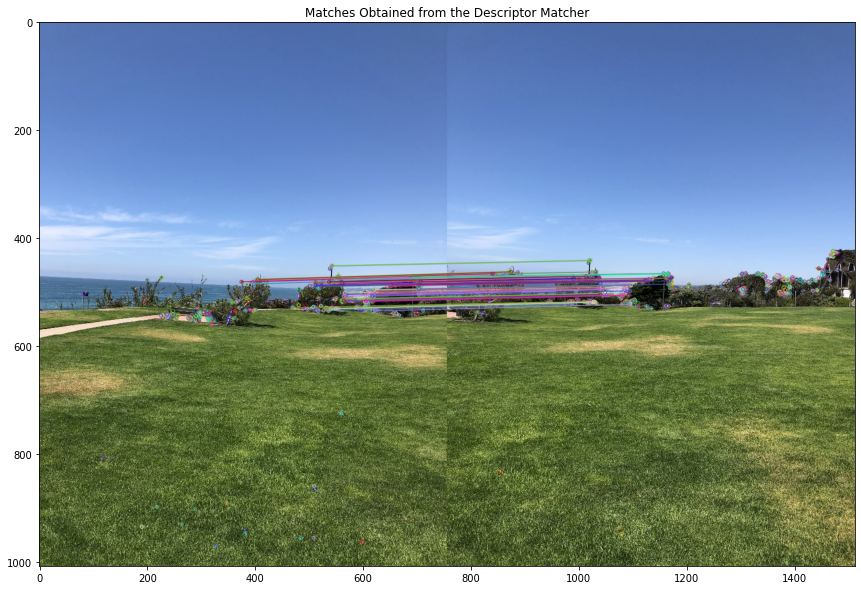

In [8]:
plt.figure(figsize = [15,10])
plt.imshow(img_matches[:,:,::-1])
plt.title("Matches Obtained from the Descriptor Matcher");

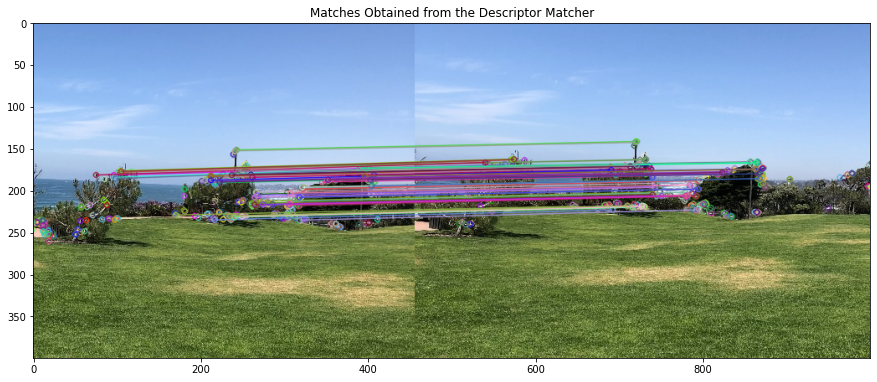

In [9]:
zoom_x1 = 300; zoom_x2 = 1300
zoom_y1 = 300; zoom_y2 = 700

plt.figure(figsize = [15,10])
img_matches_zoom = img_matches[zoom_y1:zoom_y2, zoom_x1:zoom_x2]
plt.imshow(img_matches_zoom[:,:,::-1])
plt.title("Matches Obtained from the Descriptor Matcher");

# 4. Image Alignment using Homography

A homography can be computed when we have 4 or more corresponding points in two images. Automatic feature matching explained in the previous step does not always produce 100% accurate matches. It is not uncommon for 20-30% of the matches to be incorrect. Fortunately, the `findHomography` method utilizes a robust estimation technique called Random Sample Consensus ([RANSAC](https://en.wikipedia.org/wiki/Random_sample_consensus)) which produces the right result even in the presence of a large number of bad matches. 


After matching is done, the output (matches) has the following attributes : 

* **`matches.distance`** - Distance between descriptors. Should be lower for a better match.
* **`matches.trainIdx`** - Index of the descriptor in train descriptors
* **`matches.queryIdx`** - Index of the descriptor in query descriptors
* **`matches.imgIdx`** - Index of the train image.

To simplify things, the `queryIdx` corresponds to points in image1 and `trainIdx` corresponds to points in image2. We will create two lists - `points1` and `points2` from the matching points which will serve as the final set of corresponding points to be used in the `findHomography()` function.

### <font style="color:rgb(50,120,230)">Compute the Homography</font>

In [10]:
points1 = np.zeros((len(matches), 2), dtype = np.float32)
points2 = np.zeros((len(matches), 2), dtype = np.float32)

for i, match in enumerate(matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt

# Find homography.
h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

# 5. Warp the Image
Once an accurate homography has been calculated, the transformation can be applied to all pixels in one image to map it to the other image. This is done using the `warpPerspective()` function in OpenCV.

While using the warp function, we should specify a different size of the output image(not the default size). Since we are stitching the images horizontally, we should specify the width of the output image to be the sum of both images. We can keep the height to be the same as any one of them.

In [11]:
# Warp time the perspective of the 2nd image using the homography.
img1_h, img1_w, channels = img1.shape
img2_h, img2_w, channels = img2.shape

img2_aligned = cv2.warpPerspective(img2, h, (img2_w + img1_w, img2_h))

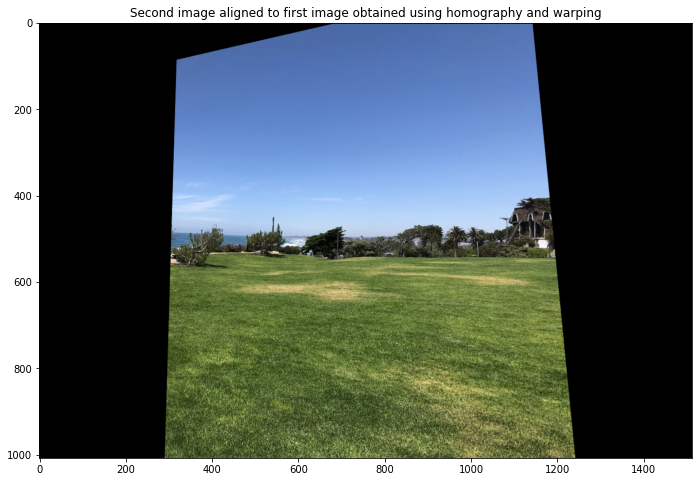

In [12]:
plt.figure(figsize = [15,8])
plt.imshow(img2_aligned[:,:,::-1])
plt.title("Second image aligned to first image obtained using homography and warping");

# 6. Stitch the Images
Finally, we can simply concatenate the first image with the aligned second image and get the stitched image. Since the second image is aligned with the first image, we can superimpose the first image on the output canvas to get the stitched image.

In [13]:
# Stitch Image-1 with aligned image-2.
stitched_image = np.copy(img2_aligned)
stitched_image[0:img1_h, 0:img1_w] = img1

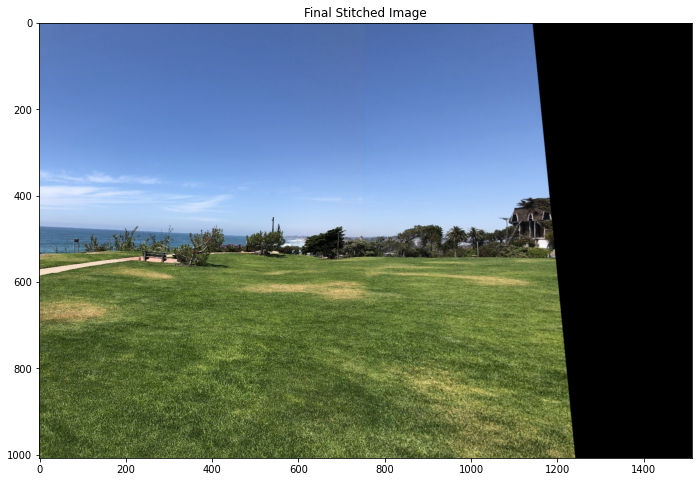

In [14]:
plt.figure(figsize = [15, 8])
plt.imshow(stitched_image[:,:,::-1])
plt.title("Final Stitched Image");

## <font style="color:rgb(50,120,230)">Conclusion</font>

This approach has some challenges: 
* There might be visible seams at the boundary of the two images. This is because of the variation in lighting/exposure between the two images.
* The lighting variation might also require some color correction as the two images might not blend well after stitching. 
* Difficult to extend to multiple images.

# Alternative: Creating Panoramas using the OpenCV Stitcher Class

In [15]:
# Read images.
imagefiles = glob.glob('./scene/*')
imagefiles.sort()
print(imagefiles)

images = []
for filename in imagefiles:
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(img)

num_images = len(images)

['./scene\\scene1.jpg', './scene\\scene2.jpg', './scene\\scene3.jpg', './scene\\scene4.jpg', './scene\\scene5.jpg', './scene\\scene6.jpg', './scene\\scene7.jpg', './scene\\scene8.jpg']


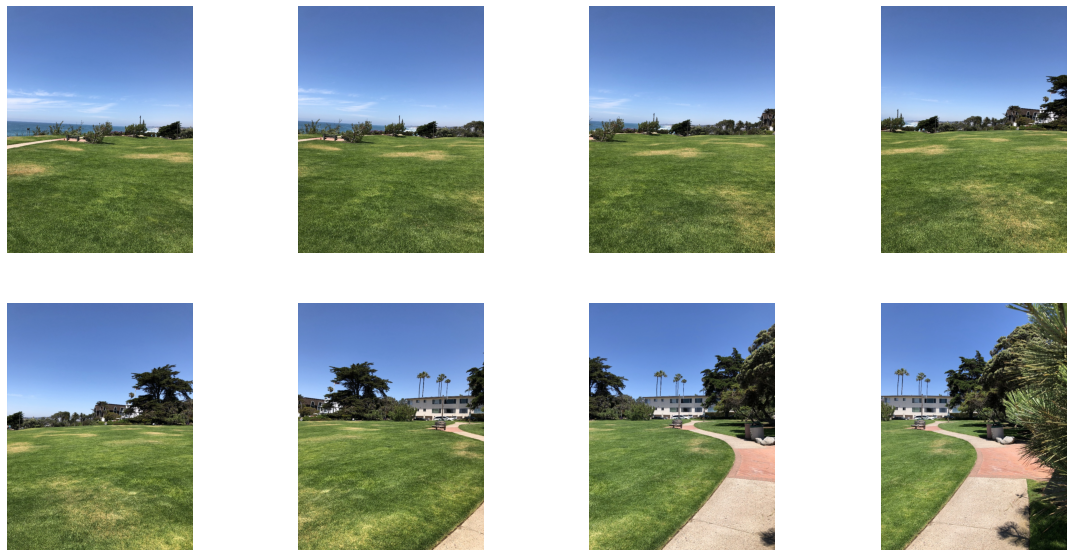

In [16]:
# Display images.
plt.figure(figsize = [20,10]) 
num_cols = 4
num_rows = math.ceil(num_images / num_cols)
for i in range(0, num_images):
    plt.subplot(num_rows, num_cols, i+1) 
    plt.axis('off')
    plt.imshow(images[i]);

<hr style="border:none; height: 4px; background-color:#D3D3D3" />


### <font color="green">Function Syntax </font>
``` python
retval = cv2.Stitcher_create([, mode])

```
The optional `mode` argument default is to create panoramas:

1. `cv2.Stitcher_PANORAMA` or `0`: Creating photo panoramas. Expects images under perspective transformation and projects resulting pano to sphere.
2. `cv2.Stitcher_SCANS` or `1`: Composing scans. Expects images under affine transformation does not compensate exposure by default.

### <font color="green">OpenCV Documentation</font>

[**`Stitcher Class`**](https://docs.opencv.org/4.5.2/d2/d8d/classcv_1_1Stitcher.html)
[**`Stitcher_create()`**](https://docs.opencv.org/4.5.2/d2/d8d/classcv_1_1Stitcher.html#a308a47865a1f381e4429c8ec5e99549f)

<hr style="border:none; height: 4px; background-color:#D3D3D3" />

<hr style="border:none; height: 4px; background-color:#D3D3D3" />


### <font color="green">Function Syntax </font>
``` python
retval, pano = cv.Stitcher.stitch(images [, pano])
```
The function has **1 required input argument**:

1. `images`: Input images.

### <font color="green">OpenCV Documentation</font>


[**`stitcher()`**](https://docs.opencv.org/4.5.2/d2/d8d/classcv_1_1Stitcher.html#a37ee5bacf229e9d0fb9f97c8f5ed1acd)


<hr style="border:none; height: 4px; background-color:#D3D3D3" />


### <font style="color:rgb(50,120,230)">Using the Stitcher Class</font>

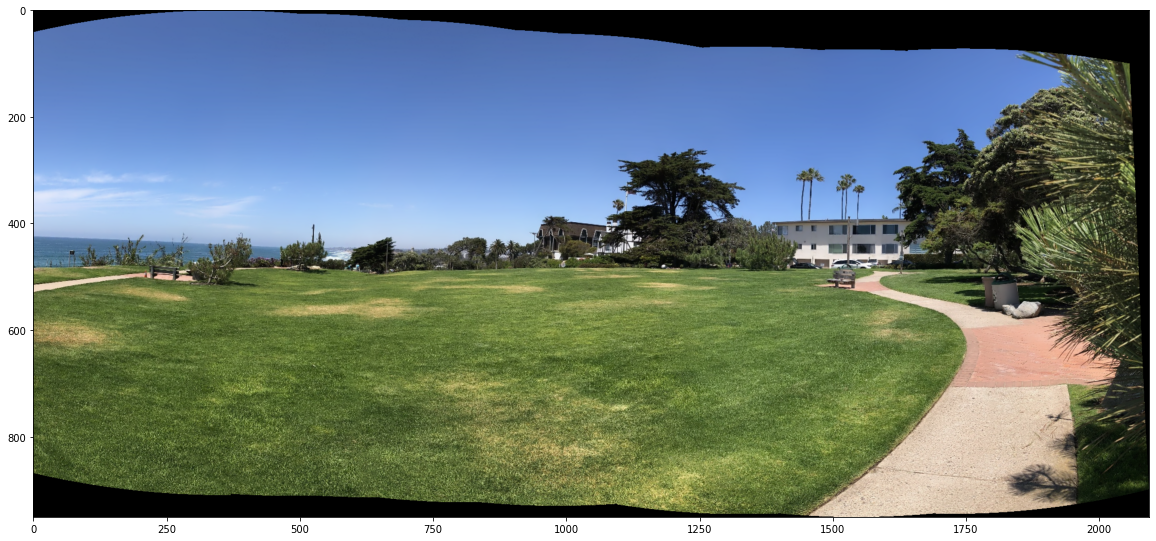

In [17]:
stitcher = cv2.Stitcher_create()
status, panorama = stitcher.stitch(images)
if status == 0:
    plt.figure(figsize = [20,10]) 
    plt.imshow(panorama)

### <font style="color:rgb(50,120,230)">Crop the Panorama</font>

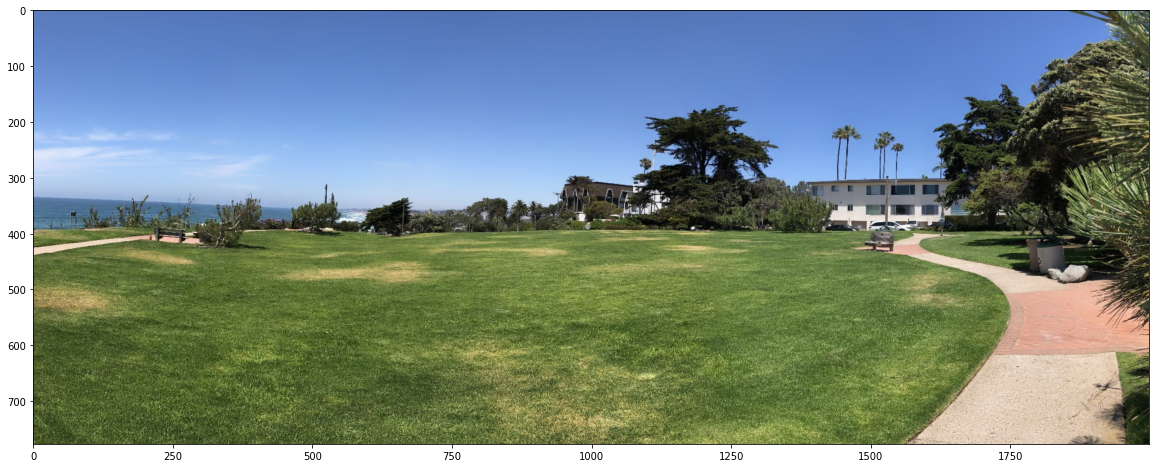

In [18]:
plt.figure(figsize = [20,10]) 
plt.imshow(panorama)
cropped_region = panorama[90:867, 1:2000]
plt.imshow(cropped_region);